## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [1]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.

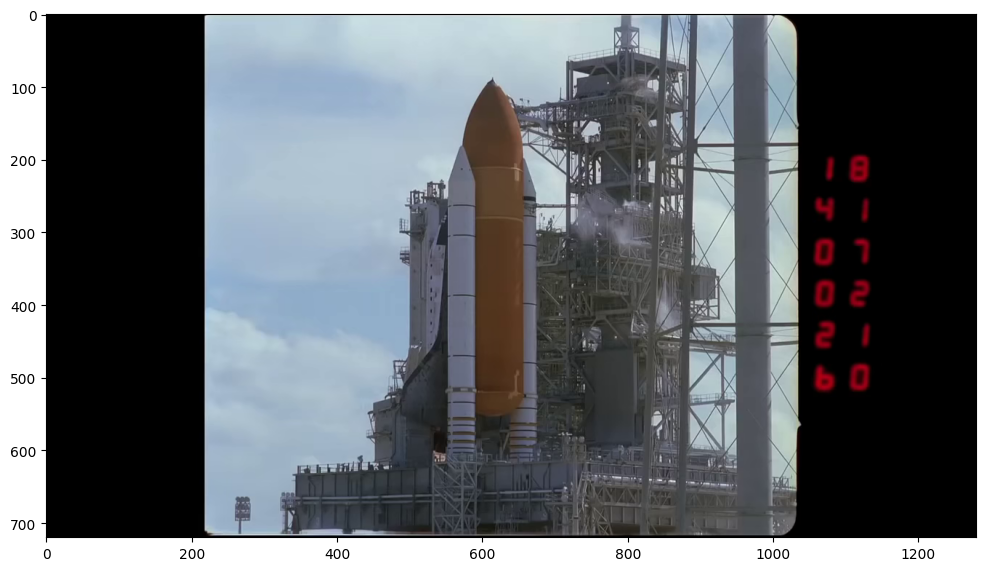

In [2]:
source = cv2.VideoCapture('shuttle.mp4')
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);

In [3]:
import cv2
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive

import matplotlib.pyplot as plt



def update_hsv(lower_h, lower_s, lower_v, upper_h, upper_s, upper_v):
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_orange = np.array([lower_h, lower_s, lower_v])
    upper_orange = np.array([upper_h, upper_s, upper_v])
    orange_mask = cv2.inRange(hsv_frame, lower_orange, upper_orange)
    orange_segment = cv2.bitwise_and(frame, frame, mask=orange_mask)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("Original Frame")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(orange_segment, cv2.COLOR_BGR2RGB))
    plt.title("Segmented Orange Mask")
    plt.show()

interactive_plot = interactive(update_hsv,
                               lower_h=widgets.IntSlider(min=0, max=179, step=1, value=10, description='Lower H'),
                               lower_s=widgets.IntSlider(min=0, max=255, step=1, value=100, description='Lower S'),
                               lower_v=widgets.IntSlider(min=0, max=255, step=1, value=100, description='Lower V'),
                               upper_h=widgets.IntSlider(min=0, max=179, step=1, value=25, description='Upper H'),
                               upper_s=widgets.IntSlider(min=0, max=255, step=1, value=255, description='Upper S'),
                               upper_v=widgets.IntSlider(min=0, max=255, step=1, value=255, description='Upper V'))

interactive_plot


interactive(children=(IntSlider(value=10, description='Lower H', max=179), IntSlider(value=100, description='L…

In [1]:
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def get_good_points(frame, feature_params, hsv_filter=[0, 80, 50, 20, 255, 255]):
    first_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    lower_h, lower_s, lower_v, upper_h, upper_s, upper_v = hsv_filter
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_orange = np.array([lower_h, lower_s, lower_v])
    upper_orange = np.array([upper_h, upper_s, upper_v])
    mask = cv2.inRange(hsv_frame, lower_orange, upper_orange)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    points = cv2.goodFeaturesToTrack(first_gray, mask=mask, **feature_params)
    return points


video_path = "shuttle.mp4"
lk_params = dict(
    winSize=(10, 10),  # Window size
    maxLevel=1,  # Number of pyramid levels
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
)

feature_params = dict(
    maxCorners=100,
    qualityLevel=0.005,
    minDistance=8,
    blockSize=4,
)

cap = cv2.VideoCapture("shuttle.mp4")
ret, old_frame = cap.read()

width = old_frame.shape[1]
height = old_frame.shape[0]
edge_treshold = 25

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

mask = np.zeros_like(old_frame)
frame_count = 0
start_time = time.time()
color = np.random.randint(0, 255, (100, 3))
p0 = get_good_points(old_frame, feature_params)
points_list = []

points_series = pd.Series(list(p0))
hisotry_dataframe = pd.DataFrame()
indexs = np.arange(len(p0))
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if (p0 is not None) and (p0.size != 0):
        p1, st, err = cv2.calcOpticalFlowPyrLK(
            old_gray, frame_gray, p0, None, **lk_params
        )
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        indexs = indexs[st[:, 0] == 1]
        good_new_series = pd.Series(
            data=list(good_new), index=indexs, name=f"t{frame_count}"
        )
        hisotry_dataframe = pd.concat([hisotry_dataframe, good_new_series], axis=1)
        keep_index = []
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel().astype(int)
            c, d = old.ravel().astype(int)
            mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
            frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)
            if (
                b < height - edge_treshold
                and a < width - edge_treshold
                and b > edge_treshold
                and a > edge_treshold
            ):
                keep_index.append(i)

        indexs = indexs[keep_index]
        old_gray = frame_gray
        p0 = good_new[keep_index].reshape(-1, 1, 2)
        frame_count += 1

        img = cv2.add(frame, mask)
        cv2.imshow("frame", img)
        if cv2.waitKey(30) & 0xFF == ord("q"):
            break
    else:
        break

while True:
    if cv2.waitKey(30) & 0xFF in [27, ord("q")]:
        break
    time.sleep(0.5)
cv2.destroyAllWindows()
cap.release()

KeyboardInterrupt: 

In [2]:
hisotry_dataframe

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t272,t273,t274,t275,t276,t277,t278,t279,t280,t281
0,"[652.11523, 216.77357]","[652.01056, 216.98215]","[652.01056, 216.98215]","[652.08685, 216.86877]","[652.183, 216.77036]","[652.14215, 216.97868]","[652.1106, 217.20381]","[652.133, 217.23244]","[652.12036, 217.00565]","[652.1411, 217.03493]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[595.1128, 519.99896]","[595.0059, 520.00305]","[595.0059, 520.00305]","[595.0038, 520.0212]","[594.9916, 520.0263]","[594.9903, 520.24133]","[594.9897, 520.24286]","[594.9888, 520.27893]","[594.99585, 520.06305]","[594.9907, 520.09814]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[649.12225, 229.735]","[649.03217, 229.9581]","[649.03217, 229.95819]","[649.06946, 229.9149]","[649.1078, 229.82939]","[649.1535, 230.04326]","[649.18524, 230.21098]","[649.1857, 230.26152]","[649.186, 229.86362]","[649.1883, 230.07732]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[646.1349, 210.78421]","[646.04095, 211.00162]","[646.04016, 210.9945]","[646.0982, 210.8723]","[646.17267, 210.75491]","[646.1154, 210.9635]","[646.0892, 211.1906]","[646.1108, 211.2284]","[646.10925, 211.00546]","[646.12823, 211.02881]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[657.0723, 252.85081]","[656.992, 252.96332]","[656.98987, 252.96194]","[657.03766, 252.91742]","[657.0343, 252.85852]","[657.05194, 253.03954]","[657.00464, 253.22029]","[656.99445, 253.25053]","[657.01636, 252.91386]","[657.009, 253.054]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"[648.9965, 490.99142]","[648.9965, 490.99142]","[648.99677, 490.98874]","[648.99896, 490.81076]","[648.9967, 490.7339]","[648.99396, 490.79224]","[648.9885, 490.97025]","[648.99884, 490.9736]","[649.0028, 490.80902]","[649.0058, 490.79416]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"[593.0202, 281.99783]","[593.0173, 281.99832]","[593.0173, 281.99832]","[593.0228, 281.93597]","[593.017, 281.87576]","[593.02167, 282.06885]","[593.0151, 282.26248]","[593.0284, 282.19226]","[593.0261, 281.97]","[593.0287, 282.18494]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"[649.15234, 522.9078]","[649.0593, 522.80084]","[649.05945, 522.8008]","[649.12604, 522.85913]","[649.1223, 522.8944]","[649.1522, 523.0022]","[649.1412, 523.1168]","[649.1436, 523.1178]","[649.15704, 523.0021]","[649.12836, 522.8963]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"[637.83704, 529.2066]","[637.6362, 529.29425]","[637.6362, 529.29425]","[637.64056, 529.2624]","[637.6761, 529.1073]","[637.6641, 529.3257]","[637.668, 529.3314]","[637.63495, 529.4354]","[637.6025, 529.3893]","[637.60065, 529.33386]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"[648.99915, 498.95688]","[648.9991, 498.95755]","[649.01245, 498.91748]","[649.0286, 498.77274]","[649.03625, 498.63367]","[649.03613, 498.76474]","[649.0352, 498.87042]","[649.0353, 498.9535]","[649.03754, 498.8355]","[649.04236, 498.82535]",...,"[696.2494, 95.56307]","[698.7786, 88.37363]","[699.0206, 78.508705]","[698.4059, 71.092834]","[699.2759, 61.66544]","[698.62054, 53.707638]","[699.96545, 45.413742]","[701.63245, 37.893417]","[702.69604, 27.420639]","[702.94293, 19.121914]"


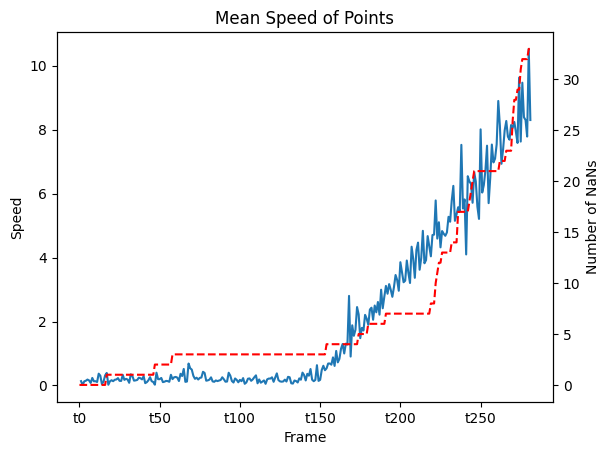

In [110]:
hisotry_dataframe.diff(axis=1)
diffs = hisotry_dataframe.diff(axis=1)
diffs.map(lambda x: np.sqrt(np.sum(x**2))).mean(axis=0).plot()
plt.title("Mean Speed of Points")
plt.xlabel("Frame")
plt.ylabel("Speed")

hisotry_dataframe.isna().sum(axis=0).plot(secondary_y=True, color='r', linestyle='--')
plt.ylabel("Number of NaNs")
plt.show()

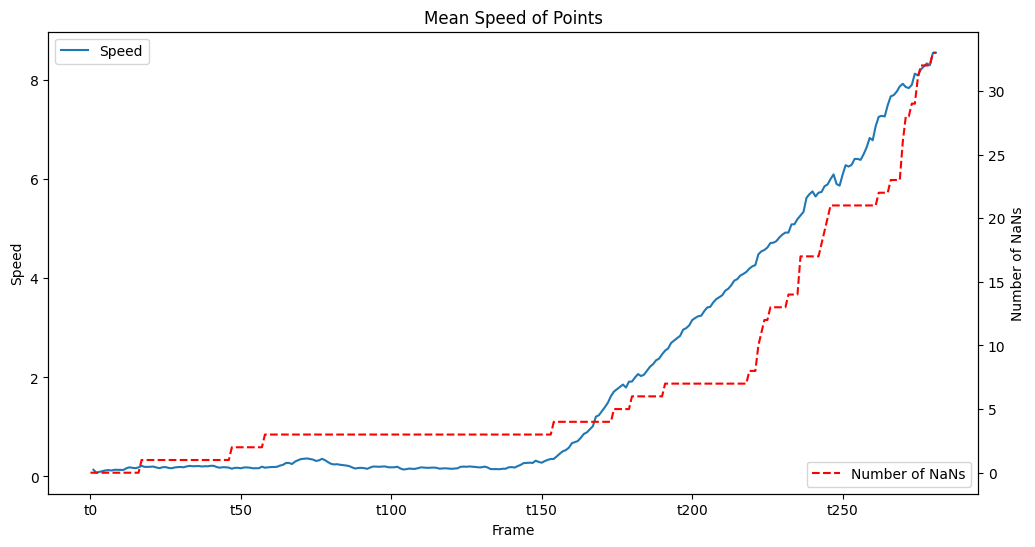

In [111]:
hisotry_dataframe.diff(axis=1)
diffs = hisotry_dataframe.diff(axis=1)
speed_mean = diffs.map(lambda x: np.sqrt(np.sum(x**2))).mean(axis=0)
filter_speed_mean = speed_mean.rolling(window=10, min_periods=1).mean()

plt.figure(figsize=(12, 6))
filter_speed_mean.plot()
plt.title("Mean Speed of Points")
plt.xlabel("Frame")
plt.ylabel("Speed")
plt.legend(["Speed"])

hisotry_dataframe.isna().sum(axis=0).plot(secondary_y=True, color='r', linestyle='--')
plt.ylabel("Number of NaNs")
plt.legend(["Number of NaNs"], loc='lower right')

plt.show()